# Probabilistic Linear Inference

## The Continuous Problem

We consider the problem of inferring an unknown model parameter $m$ from noisy observations $\mathbf{\tilde{d}}$, where $m$ lies in a separable Hilbert space $\mathcal{M}$ and $\mathbf{\tilde{d}} \in \mathcal{D}$, a finite‑dimensional Euclidean data space $\mathcal{D} \cong \mathbb{R}^{N_d}$ ($N_d \in \mathbb{N}$ is the number of data).

The relationship between the model and the data is described by a forward operator:
$$
G: \mathcal{M} \to \mathcal{D}, \quad [G(m)]_i = \langle K_i, m \rangle_{\mathcal{M}}
$$
assumed to be linear and bounded. The observed data is modeled as:
$$
\mathbf{\tilde{d}} = G(m) + \bm{\eta},
$$
where $\bm{\eta} \sim \mathcal{N}(0, \mathbf{C}_{\mathcal{D}})$ represents additive Gaussian noise with known symmetric positive‑definite covariance matrix $\mathbf{C}_{\mathcal{D}} \in \mathbb{R}^{N_d \times N_d}$.

To regularize this ill‑posed inverse problem, we adopt a Bayesian framework. We model the unknown $m$ as a random variable and assign a Gaussian prior:
$$
m \sim \mu_{\mathcal{M}}^0 := \mathcal{N}(m_0, C_0),
$$
where $m_0 \in \mathcal{M}$ is the prior mean, and $C_0: \mathcal{M} \to \mathcal{M}$ is a symmetric, positive‑definite trace‑class covariance operator.


**Gaussian measure in terms of $C_0$**  
Under this formulation the Gaussian prior can be equivalently written via its Karhunen–Loève expansion: if $\{\varphi_k\}$ are eigenfunctions of $C_0$ with eigenvalues $\{\lambda_k\}$, then
$$
m = m_0 + \sum_{k=1}^\infty \sqrt{\lambda_k} \,\bm{\xi}_k\,\varphi_k,
\qquad
\bm{\xi}_k \overset{i.i.d.}{\sim} \mathcal{N}(0,1).
$$
Thus $C_0$ controls the decay of $\lambda_k$ and hence the regularity of samples from $\mu_{\mathcal{M}}^0$.

The goal of Bayesian inversion is to compute or characterize the posterior distribution $\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}$ of $m$ conditioned on the observed data $\mathbf{\tilde{d}}$. According to Bayes’ theorem (in the infinite‑dimensional setting), the posterior is given formally by:
$$
\frac{d\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}}{d\mu_{\mathcal{M}}^0}(m) \;\propto\; \exp\!\left[-\tfrac12\,\|G(m)-\mathbf{\tilde{d}}\|_{\mathbf{C}^{-1}_{\mathcal{D}}}^2\right],
$$
where the data‐misfit norm is
$$
\|\mathbf{v}\|_{\mathbf{C}^{-1}_{\mathcal{D}}}^2 := \mathbf{v}^\top\,\mathbf{C}_{\mathcal{D}}^{-1}\,\mathbf{v}.
$$

Bayesian inference takes this a step further and asks for a specific property of the true model. Let 
$$
\mathcal{T} \colon \mathcal{M} \to \mathcal{P}, \quad [\mathcal{T}(m)]_i = \langle T_i, m \rangle_{\mathcal{M}}
$$
be a linear and bounded mapping that takes in a model and outputs a finite number of real scalars that represent some local or global property of the model, such as a global average, a local average, a local gradient average, a Fourier basis coefficient, etc. $T_i \in \mathcal{M}$ are the target kernels. The property space $\mathcal{P}$ is a finite dimensional Hilbert space equivalent to $\mathbb{R}^{N_p}$ where $N_p \in \mathbb{N}$ is the number of "properties" to be sought. By pushing the infinite-dimensional posterior measure $\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}$ through the property mapping $\mathcal{T}$ we obtain the (Gaussian) property measure 
$$
\mu_{\mathcal{P}} = \mathcal{T}_*\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}
$$

## Continuous Solution

Using a Bayesian update we obtain the posterior measure on the model space $\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\tilde{m}, C_{\mathcal{M}})$ where:
$$
\boxed{
C_{\mathcal{M}} = \left( G^* \mathbf{C}_{\mathcal{D}}^{-1} G + C_0^{-1} \right)^{-1}, \quad
\tilde{m} = C_{\mathcal{M}} \left( G^* \mathbf{C}_{\mathcal{D}}^{-1} \mathbf{\tilde{d}} + C_0^{-1}m_0 \right).
}
$$

Then we can obtain the property measure from the model posterior $\mu_{\mathcal{P}} = \mathcal{N}(\mathbf{\tilde{p}}, \mathbf{C}_{\mathcal{P}})$:
$$
\boxed{
\mathbf{\tilde{p}} = \mathcal{T}(\tilde{m}), \quad \mathbf{C}_{\mathcal{P}} = \mathcal{T} C_{\mathcal{M}} \mathcal{T}^*.
}
$$


### Importing the necessary packages

In [1]:
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.interval.operators import SOLAOperator
from pygeoinf.interval.l2_functions import Function
from pygeoinf.gaussian_measure import GaussianMeasure
import matplotlib.pyplot as plt
import numpy as np
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.operators import LaplacianInverseOperator
from pygeoinf.forward_problem import LinearForwardProblem
from pygeoinf.bayesian import LinearBayesianInference
from pygeoinf.linear_solvers import CholeskySolver

# Set-up folder for saving figures
import os
figures_folder = 'pli_figures'
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/random_matrix.py:6: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.linalg import (


## Creating the spaces

We first create the function domain as an interval. The model space will be an $L^2$ space with $N$ basis function of type fourier. 

In [52]:
# Create a function domain and spaces
function_domain = IntervalDomain(0, 1)
N = 30 # number of basis functions
M = L2Space(N, function_domain, basis_type='sine') # model space
N_d = 100 # number of data points
D = EuclideanSpace(N_d) # data space
N_p = 10 # number of property points
P = EuclideanSpace(N_p) # property space

## Create mappings

In [84]:
# Create forward and property mappings
width = 0.1 # width of the bump target functions
centers = np.linspace(function_domain.a + width / 2, function_domain.b - width / 2, N_p) # centers of the bumps
# Create a normal modes provider for the forward operator
# and a bump function provider for the target operator
# Note: The random_state is set to ensure reproducibility of results
normal_modes_provider = NormalModesProvider(M, gaussian_width_percent_range=(5, 10),
                                            freq_range=(5, 10), random_state=39)
G = SOLAOperator(M, D, normal_modes_provider, integration_method='trapz', n_points=1000)
target_provider = BumpFunctionProvider(M, centers=centers, default_width=width, default_k=0.0)
T = SOLAOperator(M, P, target_provider, integration_method='trapz', n_points=1000)

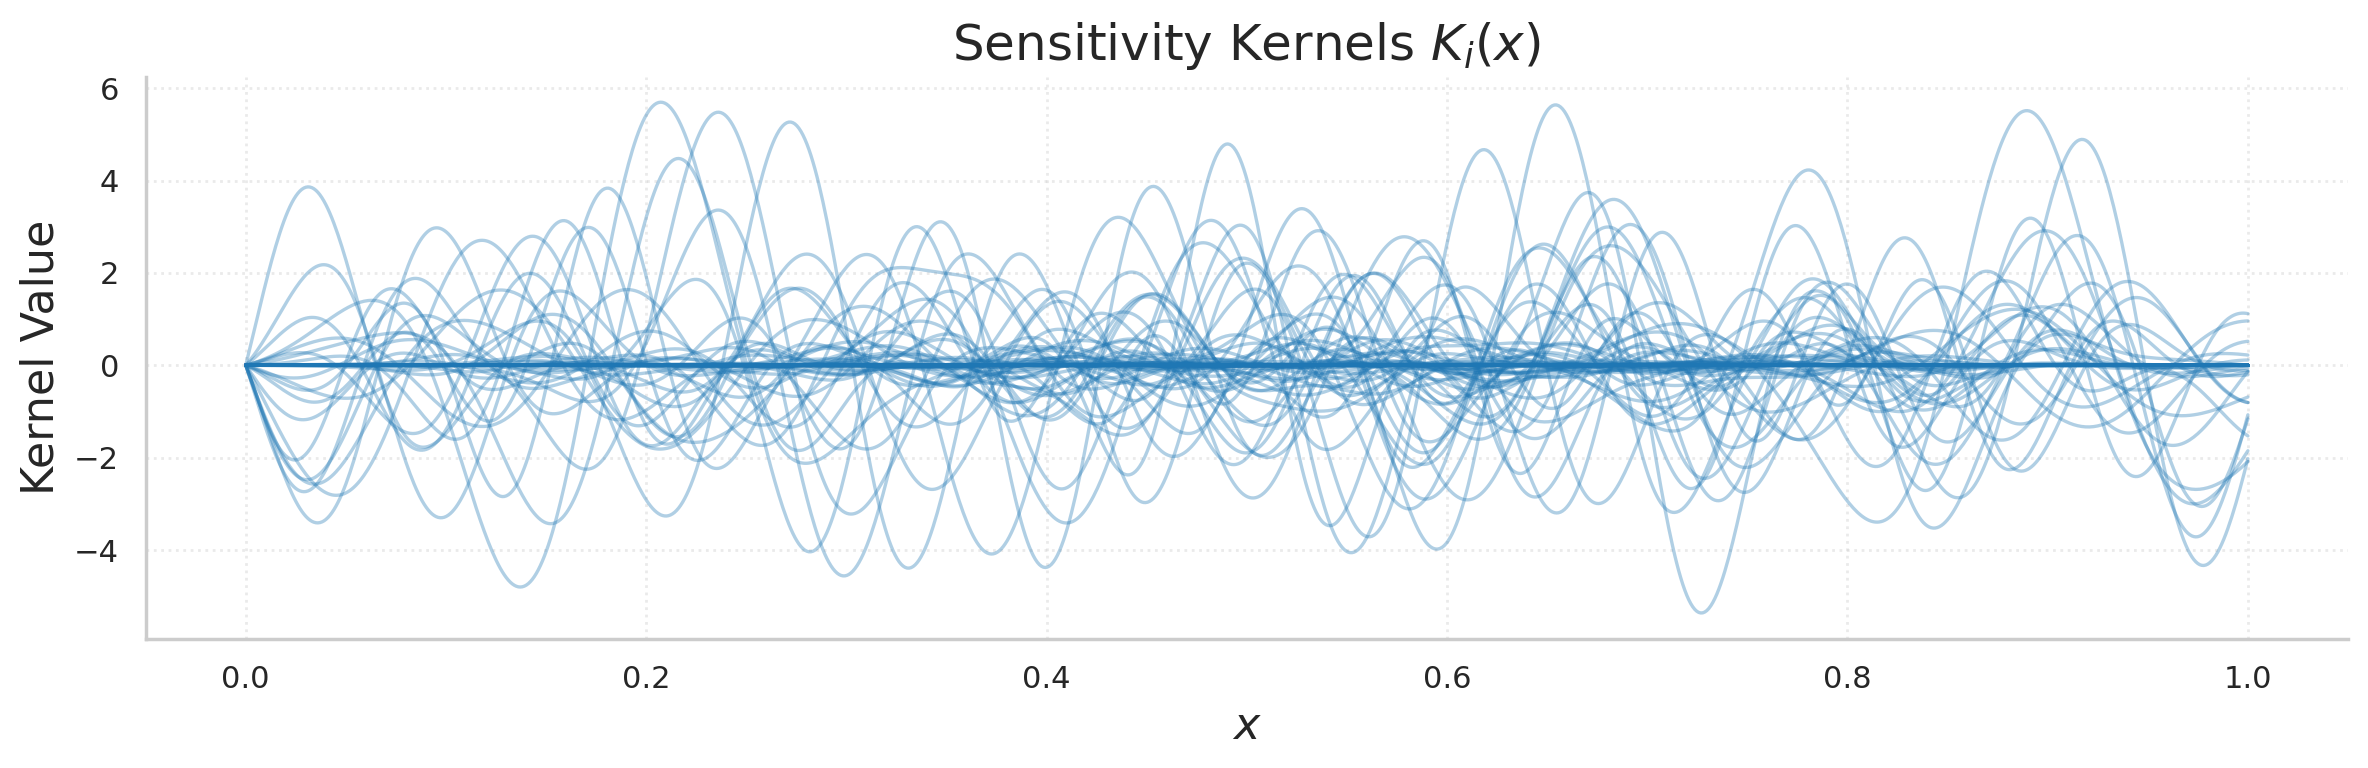

In [85]:
# Publication-quality Sensitivity Kernels figure
fig_title = "Sensitivity Kernels"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

x = np.linspace(function_domain.a, function_domain.b, 1000)

import seaborn as sns
sns.set_theme(style="whitegrid", palette="muted", color_codes=True)
plt.figure(figsize=(12, 4), dpi=200)

# Plot all kernels in a single color - overlapping areas show regions of high sensitivity
for i in range(N_d):
    plt.plot(
        x,
        G.function_provider.get_function_by_index(i).evaluate(x),
        color='tab:blue',
        alpha=0.35,
        linewidth=1.2
    )

plt.title(r"Sensitivity Kernels $K_i(x)$", fontsize=18)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel("Kernel Value", fontsize=16)
plt.tight_layout()
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()

# Save as both PNG and PDF for publication
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

### Sensitivity Kernels Visualization

The sensitivity kernels $K_i(x)$ define how sensitive each data point $d_i$ is to the model $m(x)$ at different spatial locations. These kernels are crucial for understanding:

- **Coverage**: Where in the domain we have observational sensitivity
- **Resolution**: How localized our measurements are
- **Redundancy**: Overlapping kernels indicate multiple measurements of similar information

Regions where many kernels overlap (appearing darker) represent areas of high observational density, while sparse regions indicate limited sensitivity.

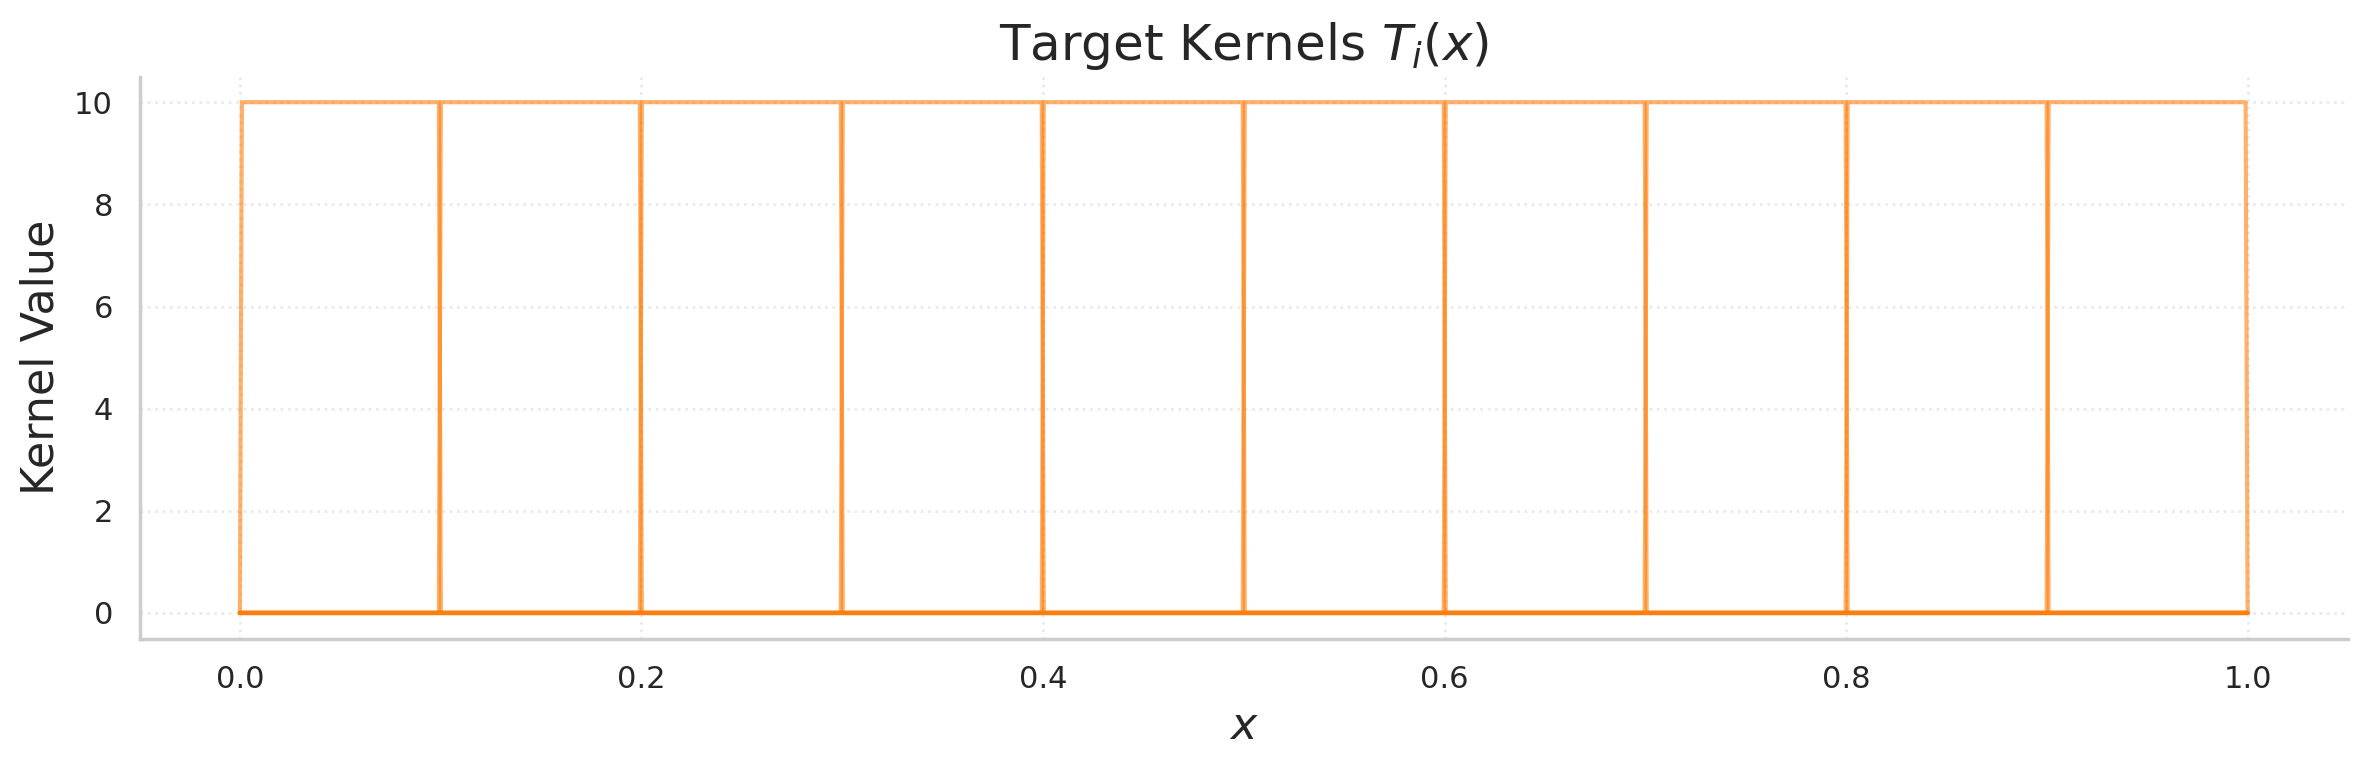

In [86]:
# Publication-quality Target Kernels figure
fig_title = "Target Kernels"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
for i in range(N_p):
    plt.plot(
        x,
        T.function_provider.get_function_by_index(i).evaluate(x),
        color='tab:orange',
        alpha=0.6,
        linewidth=1.5
    )

plt.title(r"Target Kernels $T_i(x)$", fontsize=18)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel("Kernel Value", fontsize=16)
plt.tight_layout()
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()

# Save as both PNG and PDF
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

### Target Kernels for Property Extraction

The target kernels $T_i(x)$ define the properties we want to infer about the model. Each kernel extracts a local average of the model around its center location. These bump functions allow us to:

- **Localize**: Extract spatially localized properties
- **Regularize**: Smooth local estimates through spatial averaging  
- **Focus**: Target specific regions of interest in the domain

## Synthetic Data Generation

### True Model Construction

We create a synthetic "true" model $\bar{m}(x)$ that combines multiple scales of variation:

$$\bar{m}(x) = \exp\left(-\frac{(x - 0.5)^2}{0.5^2}\right) \sin(5\pi x) + x$$

This model includes:
- **Global trend**: Linear component $x$ 
- **Localized oscillation**: Gaussian-windowed sine wave for fine-scale structure
- **Smooth envelope**: Exponential decay for spatial localization

From this true model, we generate synthetic observations $\mathbf{\bar{d}} = G(\bar{m})$ and add noise to create realistic measurements $\mathbf{\tilde{d}}$.

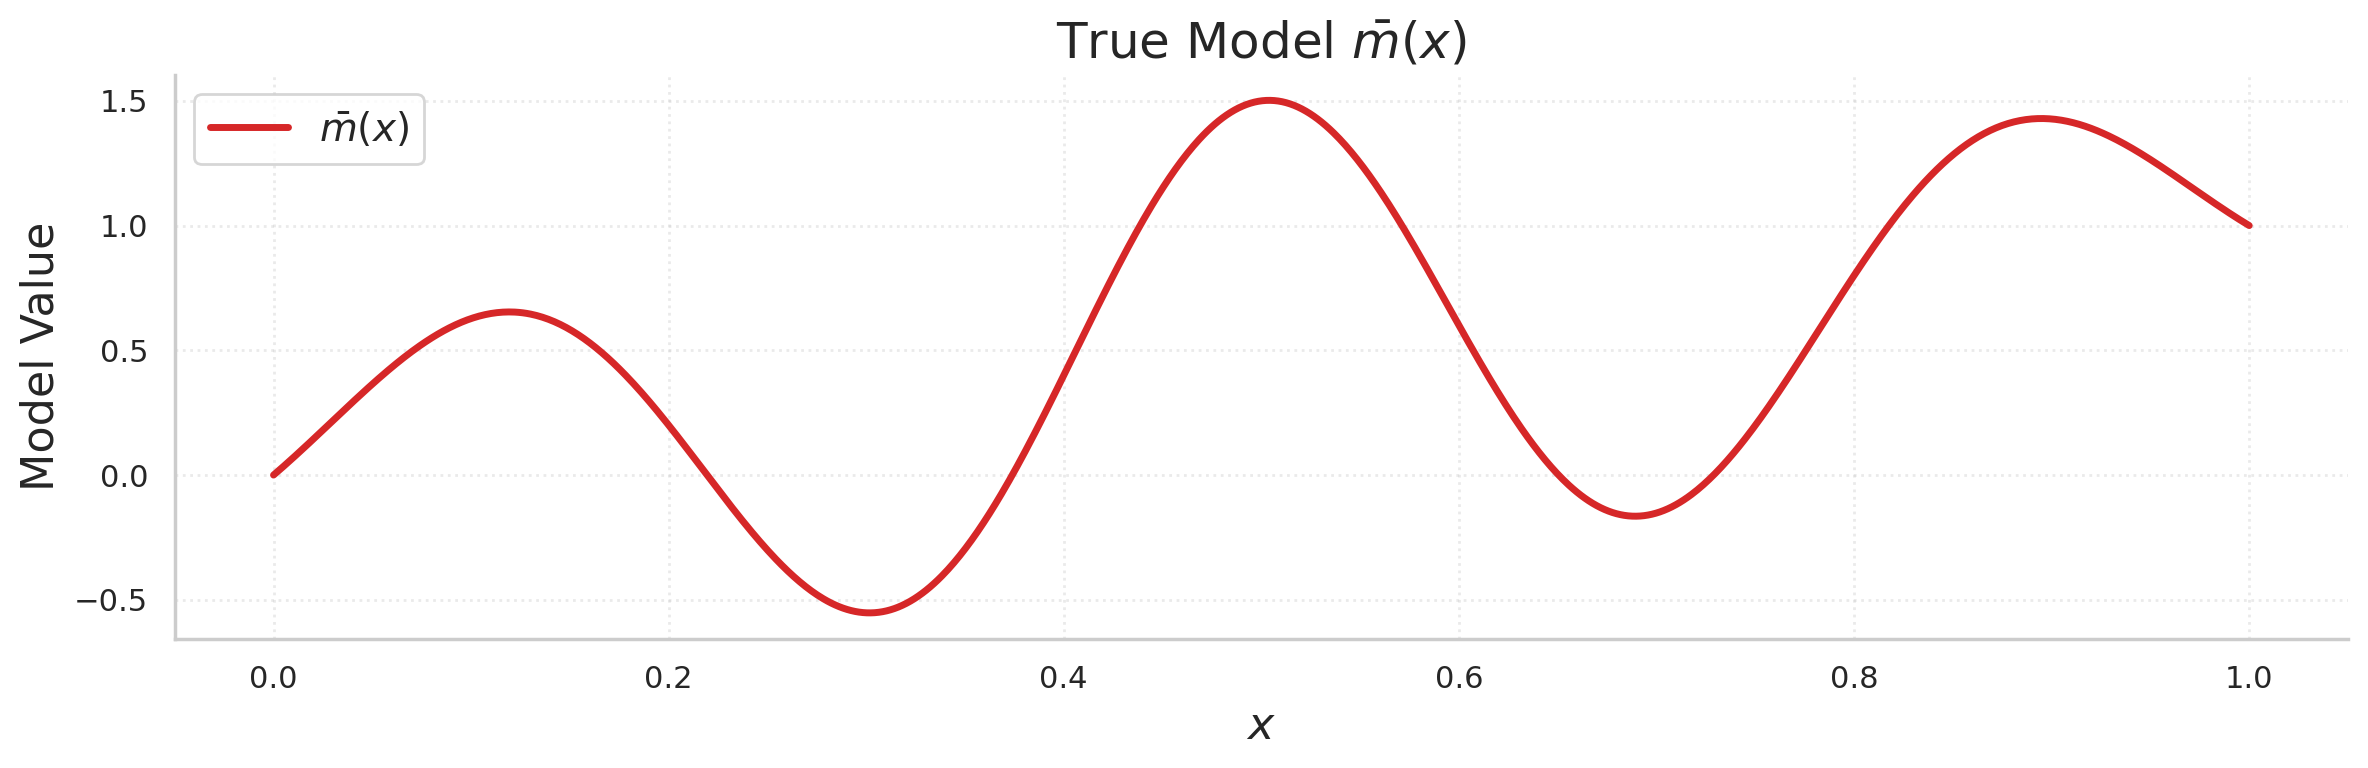

Generating synthetic data...
Signal-to-noise ratio: 10.0
Number of observations: 100


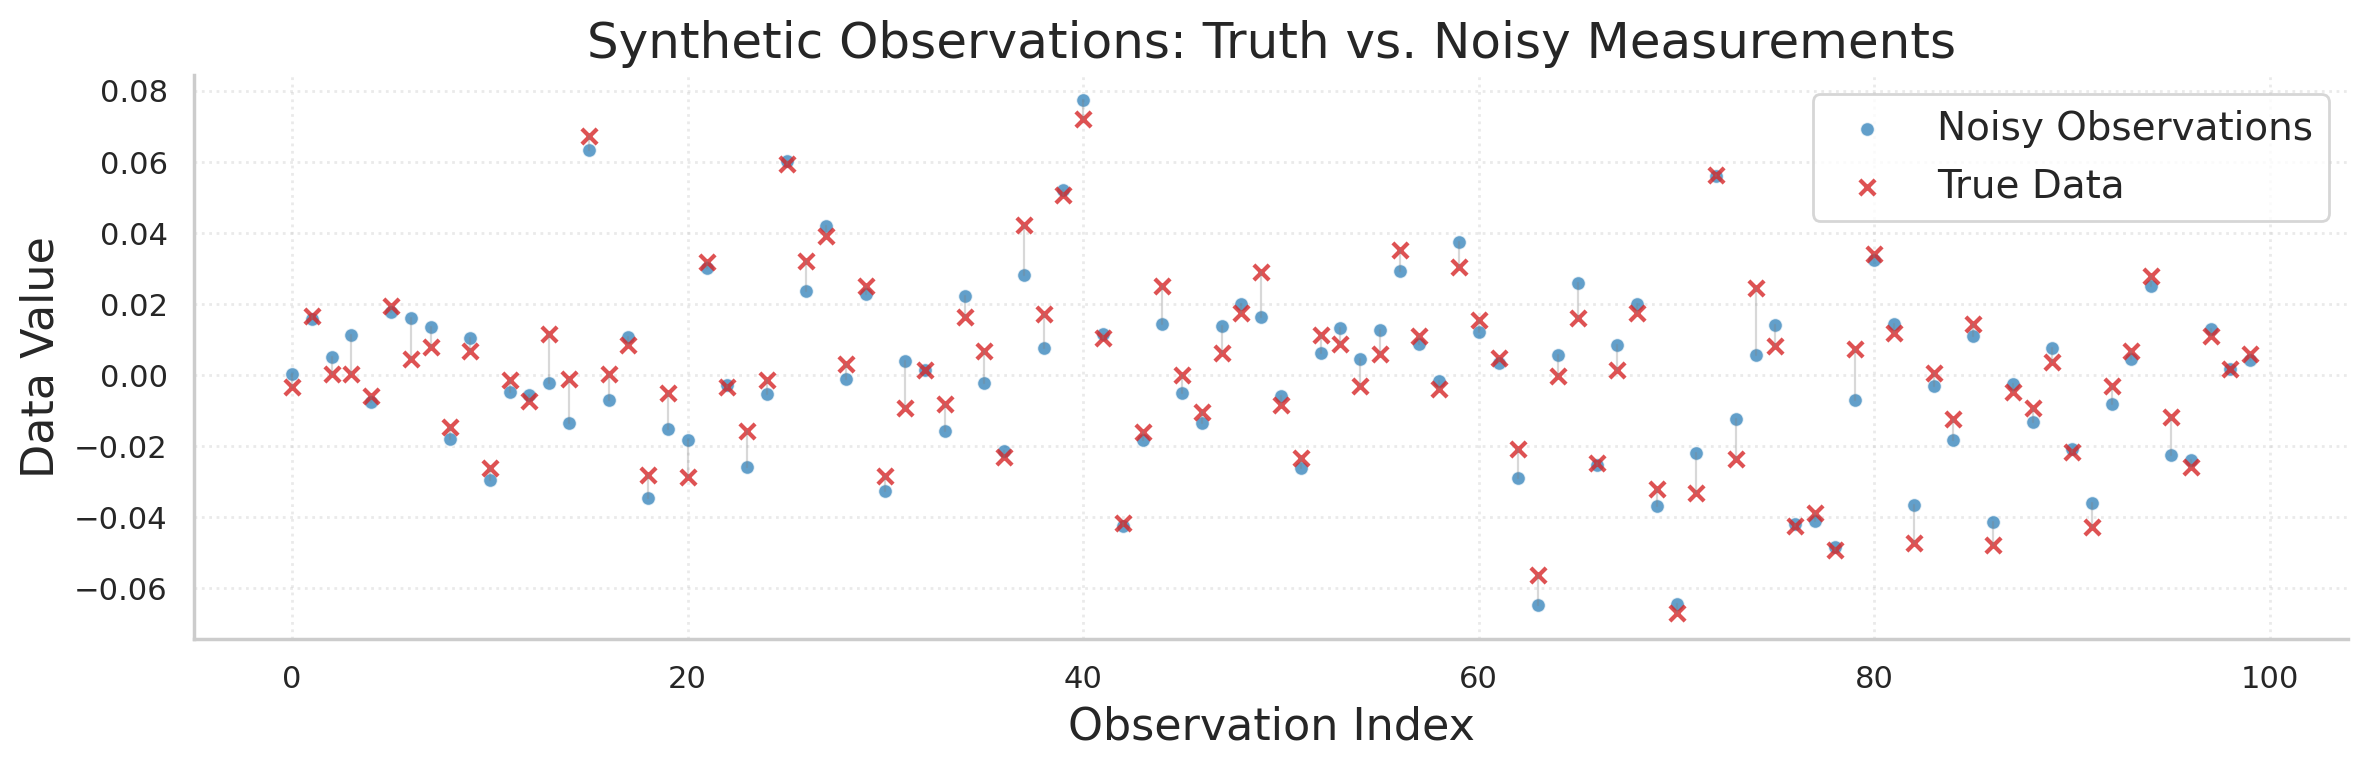

In [87]:
# Create the synthetic true model
m_bar = Function(M, evaluate_callable=lambda x: np.exp(-((x - function_domain.center)/0.5)**2) * np.sin(5 * np.pi * x) + x)

# Publication-quality true model plot
fig_title = "True Model"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(x, m_bar.evaluate(x), color='tab:red', linewidth=2.5, label=r'$\bar{m}(x)$')
plt.title(r"True Model $\bar{m}(x)$", fontsize=18)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel("Model Value", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Generate synthetic observations
print("Generating synthetic data...")
d_bar = G(m_bar)  # Clean observations
noise_level = 0.1 * np.max(d_bar)
np.random.seed(42)  # For reproducibility
d_tilde = d_bar + np.random.normal(0, noise_level, d_bar.shape)  # Noisy observations

print(f"Signal-to-noise ratio: {np.max(d_bar) / noise_level:.1f}")
print(f"Number of observations: {len(d_tilde)}")

# Publication-quality data comparison plot
fig_title = "Synthetic Observations"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
data_indices = np.arange(len(d_bar))

# Plot connection lines between true and noisy data
for i in range(len(d_bar)):
    plt.plot([i, i], [d_bar[i], d_tilde[i]], color='gray', alpha=0.3, linewidth=0.8)

# Plot the data points
plt.scatter(data_indices, d_tilde, label='Noisy Observations',
           color='tab:blue', alpha=0.7, marker='o', s=25, edgecolors='white', linewidths=0.5)
plt.scatter(data_indices, d_bar, label='True Data',
           color='tab:red', alpha=0.8, marker='x', s=30, linewidths=1.5)

plt.xlabel('Observation Index', fontsize=16)
plt.ylabel('Data Value', fontsize=16)
plt.title('Synthetic Observations: Truth vs. Noisy Measurements', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

## Bayesian Setup: Data and Prior Measures

### Data Noise Model

We model the measurement noise as independent Gaussian with known variance:
$$\mathbf{\eta} \sim \mathcal{N}(\mathbf{0}, \mathbf{C}_{\mathcal{D}})$$

where $\mathbf{C}_{\mathcal{D}} = \sigma^2 \mathbf{I}$ represents uncorrelated measurement errors. This gives us the data likelihood:
$$\mathbf{\tilde{d}} | m \sim \mathcal{N}(G(m), \mathbf{C}_{\mathcal{D}})$$

**Important distinction**: 
- **Data error measure**: $\mathcal{N}(\mathbf{0}, \mathbf{C}_{\mathcal{D}})$ - represents the noise model for `LinearForwardProblem`
- **Data measure**: $\mathcal{N}(\mathbf{\tilde{d}}, \mathbf{C}_{\mathcal{D}})$ - represents the observed data for visualization

In [88]:
# Define data noise covariance
noise_variance = (0.1 * np.max(d_tilde))**2  # 10% of peak signal
C_D_matrix = noise_variance * np.eye(N_d)

print(f"Data noise standard deviation: {np.sqrt(noise_variance):.4f}")
print(f"Relative noise level: {100 * np.sqrt(noise_variance) / np.max(d_tilde):.1f}%")

# Create data ERROR measure (zero mean) for LinearForwardProblem
# This represents the noise model: η ~ N(0, C_D)
gaussian_D_error = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=np.zeros(N_d))

# Create data measure (with observed data mean) for visualization
# This represents the likelihood: d̃ | m ~ N(G(m), C_D)
gaussian_D = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=d_tilde)

Data noise standard deviation: 0.0077
Relative noise level: 10.0%


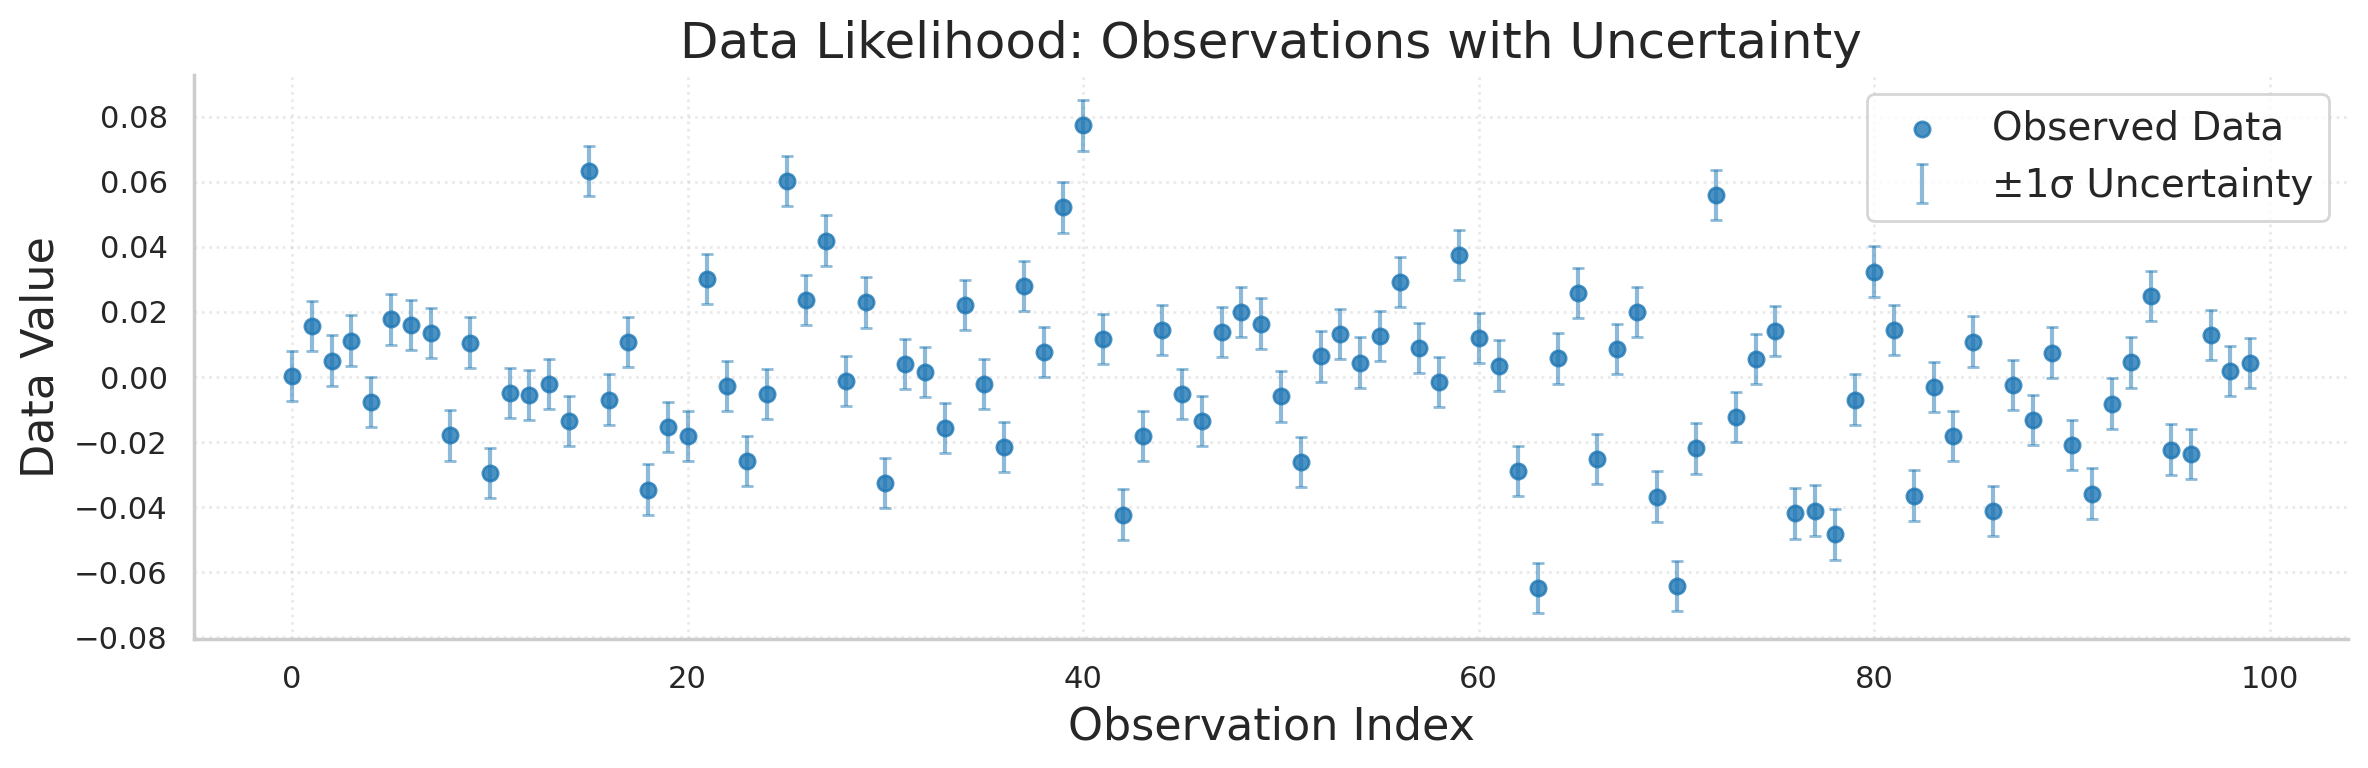

In [89]:
# Visualize the data measure (observed data with uncertainty)
# Note: We use gaussian_D (with data mean) for visualization, not gaussian_D_error (zero mean)
mean_values = gaussian_D.expectation
std_values = np.sqrt(np.diag(gaussian_D.covariance.matrix(dense=True)))

fig_title = "Data Likelihood Distribution"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
data_indices = np.arange(len(mean_values))

plt.scatter(data_indices, mean_values, label='Observed Data', color='tab:blue', alpha=0.8, s=30)
plt.errorbar(data_indices, mean_values, yerr=std_values, fmt='none',
            color='tab:blue', alpha=0.5, capsize=2, capthick=1,
            label='±1σ Uncertainty')

plt.title("Data Likelihood: Observations with Uncertainty", fontsize=18)
plt.xlabel('Observation Index', fontsize=16)
plt.ylabel('Data Value', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

### Prior Model

We assign a Gaussian prior measure to regularize the inverse problem:
$$m \sim \mu_{\mathcal{M}}^0 = \mathcal{N}(m_0, C_0)$$

**Prior Mean**: $m_0(x) = x$ (simple linear trend)

**Prior Covariance**: We use the inverse of a scaled Laplacian operator:
$$C_0 = (-\alpha \Delta)^{-1}$$

where $\alpha > 0$ controls the correlation length scale. This choice:
- Enforces smooth realizations (derivatives are penalized)
- Has explicit eigenfunction expansion using sine basis
- Provides fast sampling via Karhunen-Loève expansion

In [90]:
# Define prior measure parameters
bc_dirichlet = BoundaryConditions(bc_type='dirichlet', left=0, right=0)
alpha = 0.1  # Correlation length parameter (smaller α → longer correlations)
C_0 = LaplacianInverseOperator(M, bc_dirichlet, alpha=alpha)

# Prior mean (simple linear trend)
m_0 = Function(M, evaluate_callable=lambda x: x)

print(f"Prior covariance: (-{alpha}Δ)⁻¹ with Dirichlet boundary conditions")
print(f"Prior mean: m₀(x) = x")

# Set up Karhunen-Loève expansion for efficient sampling
K = 500  # Number of KL terms (should be ≥ N for full representation)
print(f"Using {K} Karhunen-Loève terms for prior sampling")

# Create Gaussian measure on model space
M.create_gaussian_measure(method='kl', kl_expansion=K, covariance=C_0, expectation=m_0)

# Display eigenvalue decay
eigenvals = C_0.get_all_eigenvalues(min(50, N))
print(f"Eigenvalue range: [{eigenvals[-1]:.2e}, {eigenvals[0]:.2e}]")
print(f"Spectral decay rate: {eigenvals[0]/eigenvals[-1]:.1e}")

DOLFINx found but has compatibility issues, using native solver
LaplacianInverseOperator initialized with native solver, dirichlet(left=0, right=0) BCs
Prior covariance: (-0.1Δ)⁻¹ with Dirichlet boundary conditions
Prior mean: m₀(x) = x
Using 500 Karhunen-Loève terms for prior sampling
Eigenvalue range: [1.13e-04, 1.01e-01]
Spectral decay rate: 9.0e+02


### Prior Measure Visualization

The Gaussian prior encodes our beliefs about the model before seeing data. We can visualize this through:
- **Samples**: Random realizations from the prior
- **Mean**: Expected model structure  
- **Uncertainty**: Point-wise standard deviation showing prior variability

Drawing samples from prior measure...
Computing prior uncertainty...


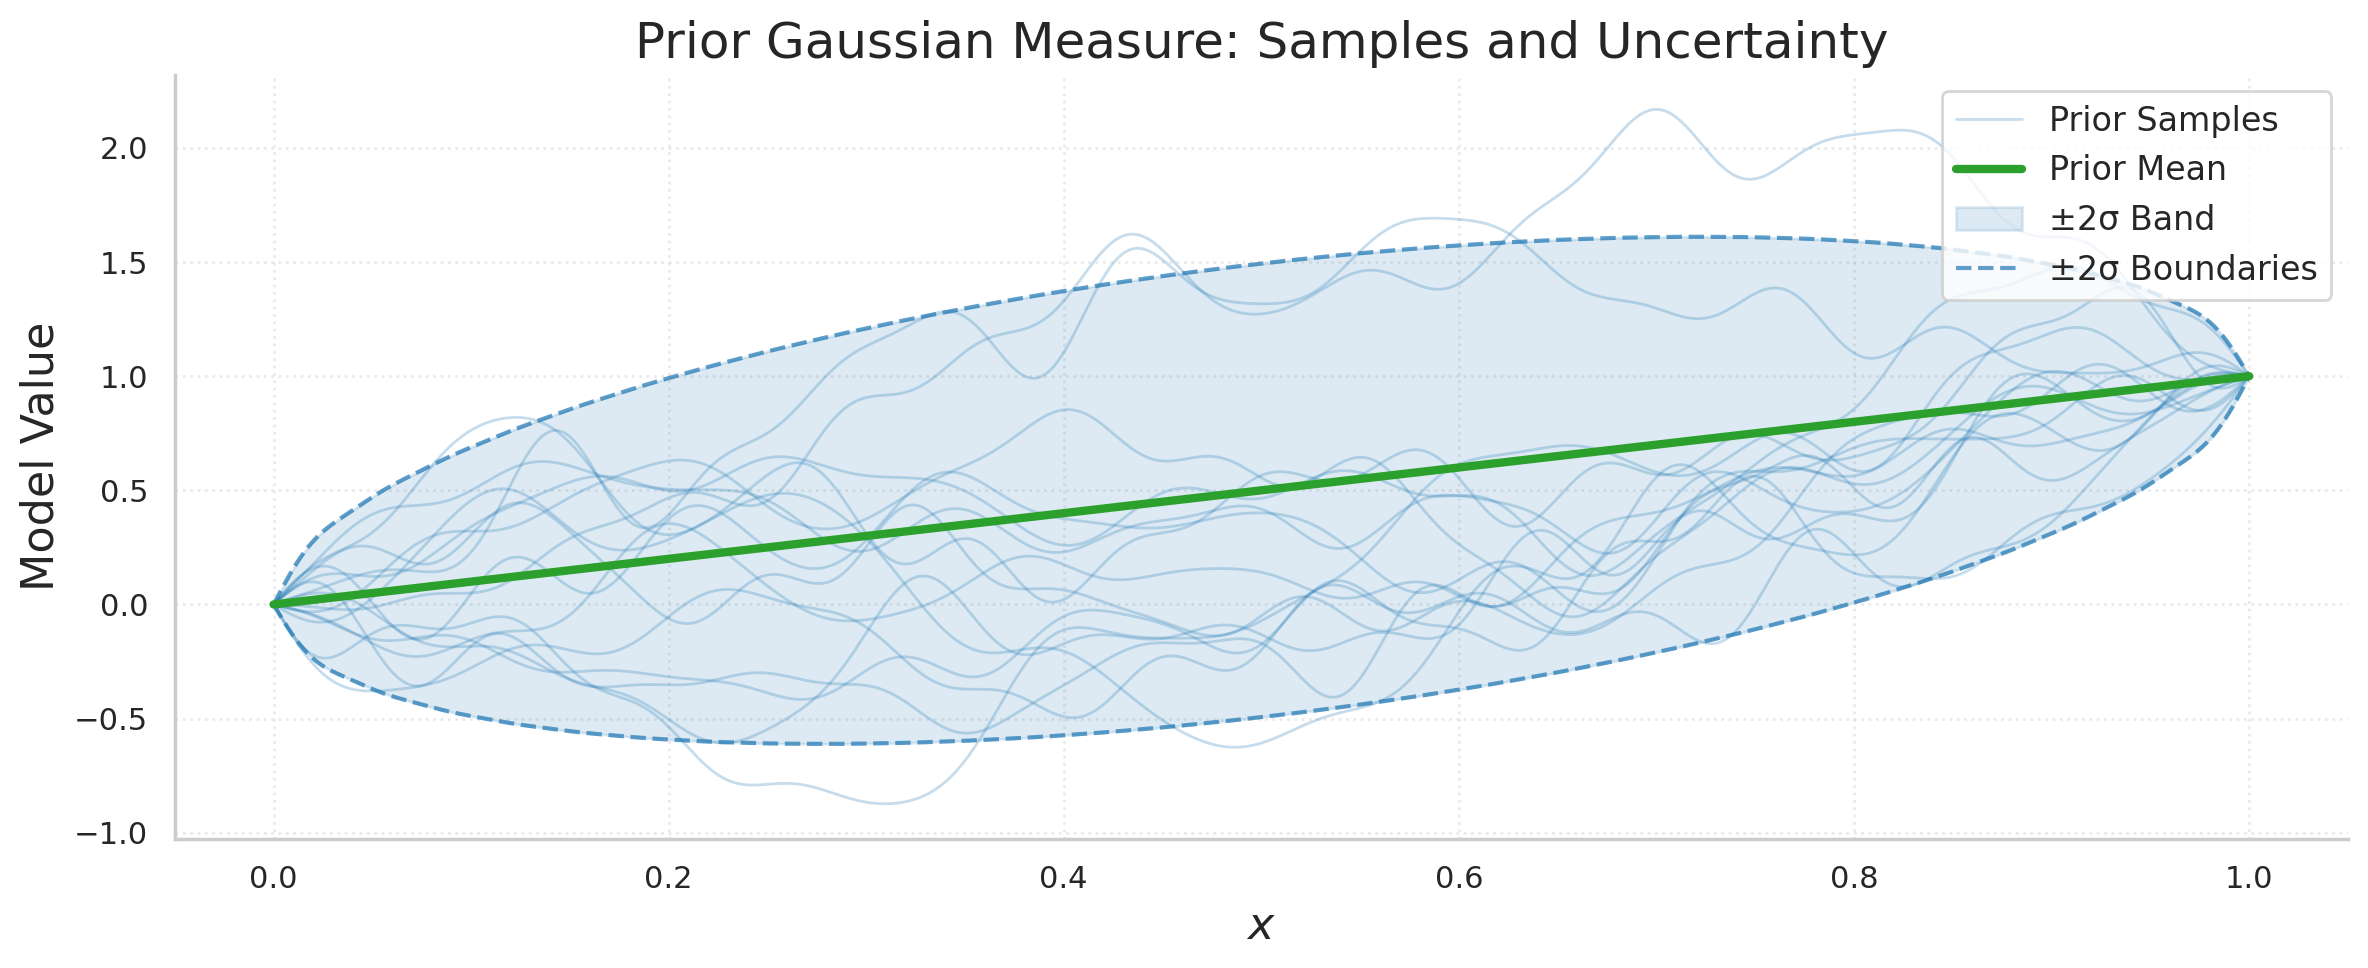

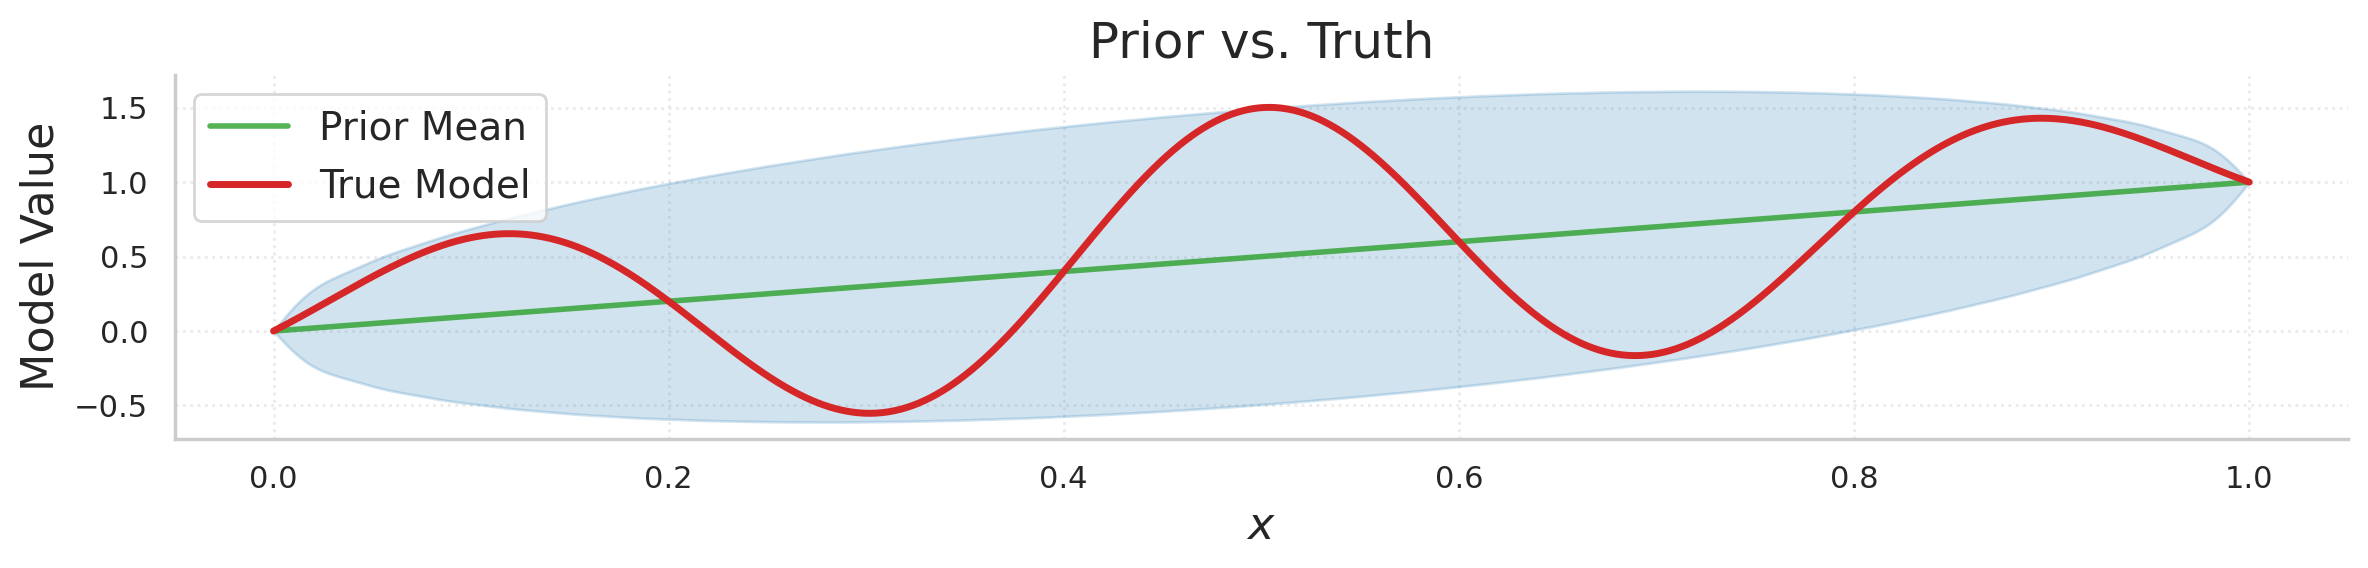

In [91]:
# Visualize the prior measure
fig_title = "Prior Measure on Model Space"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 5), dpi=200)

# Parameters for visualization
num_samples = 15
sample_color = 'tab:blue'
mean_color = 'tab:green'
std_color = 'tab:blue'

# Plot prior samples
print("Drawing samples from prior measure...")
for i in range(num_samples):
    sample = M.gaussian_measure.sample()
    plt.plot(x, sample.evaluate(x), color=sample_color, alpha=0.25, linewidth=1,
            label='Prior Samples' if i == 0 else "")

# Compute and plot uncertainty bounds
print("Computing prior uncertainty...")
std = M.zero
for i, eigenvalue in enumerate(C_0.spectrum_provider.get_all_eigenvalues()[:100]):
    eigenfunction = C_0.spectrum_provider.get_eigenfunction(i)
    std += eigenvalue * eigenfunction * eigenfunction
std_values = np.sqrt(std.evaluate(x))

# Plot prior mean
mean_values = M.gaussian_measure.expectation.evaluate(x)
plt.plot(x, mean_values, color=mean_color, linewidth=3, label='Prior Mean', zorder=10)

# Plot uncertainty bands
plt.fill_between(x, mean_values - 2*std_values, mean_values + 2*std_values,
                color=std_color, alpha=0.15, label='±2σ Band')
plt.plot(x, mean_values + 2*std_values, color=std_color, linestyle='--',
        alpha=0.7, linewidth=1.5, label='±2σ Boundaries')
plt.plot(x, mean_values - 2*std_values, color=std_color, linestyle='--',
        alpha=0.7, linewidth=1.5)

plt.title("Prior Gaussian Measure: Samples and Uncertainty", fontsize=18)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel("Model Value", fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Plot true model for comparison
plt.figure(figsize=(12, 3), dpi=200)
plt.plot(x, mean_values, color=mean_color, linewidth=2, label='Prior Mean', alpha=0.8)
plt.plot(x, m_bar.evaluate(x), color='tab:red', linewidth=2.5, label='True Model')
plt.fill_between(x, mean_values - 2*std_values, mean_values + 2*std_values,
                color=std_color, alpha=0.2)
plt.title("Prior vs. Truth", fontsize=18)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel("Model Value", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

## Property Prior Analysis

### Push-forward of Model Prior

The property prior is obtained by pushing the model prior through the target operator:
$$\mu_{\mathcal{P}}^0 = \mathcal{T}_* \mu_{\mathcal{M}}^0 = \mathcal{N}(\mathcal{T}(m_0), \mathcal{T} C_0 \mathcal{T}^*)$$

This gives us prior beliefs about the local properties before incorporating data.

In [92]:
# Compute property prior by pushing model prior through target operator
print("Computing property prior measure...")
prior_P = M.gaussian_measure.affine_mapping(operator=T)
std_P = np.sqrt(np.diag(prior_P.covariance.matrix(dense=True)))

print(f"Property prior computed for {N_p} target locations")
print(f"Property uncertainty range: [{std_P.min():.3f}, {std_P.max():.3f}]")

Computing property prior measure...
Property prior computed for 10 target locations
Property uncertainty range: [0.530, 1.528]


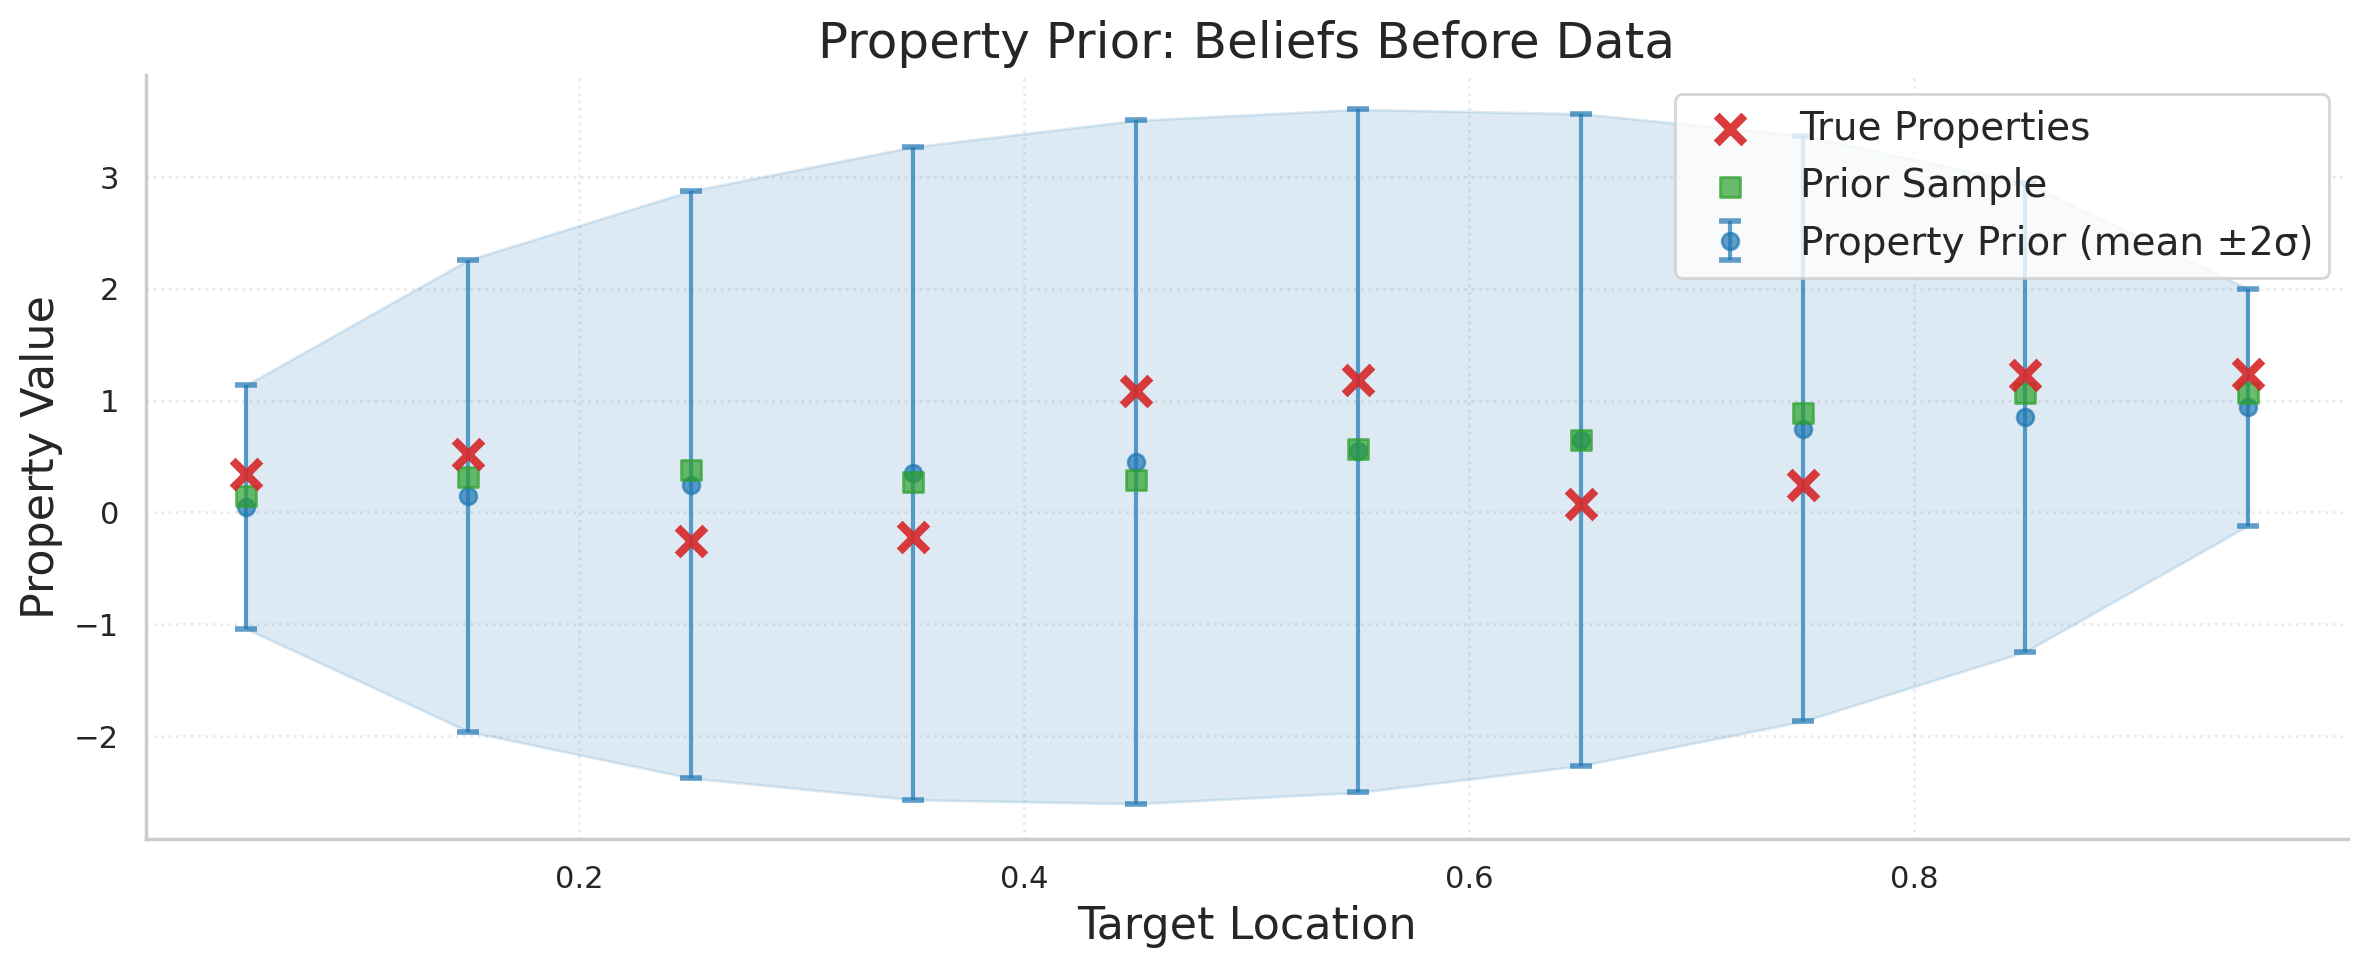

True properties range: [-0.257, 1.237]
How many true properties are within prior ±2σ: 10/10


In [93]:
# Visualize property prior
fig_title = "Property Prior Distribution"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 5), dpi=200)

# Property prior mean and uncertainty
mean_prop = T(M.gaussian_measure.expectation)
plt.errorbar(centers, mean_prop, yerr=2*std_P, fmt='o', color='tab:blue',
            alpha=0.7, capsize=4, capthick=2, markersize=6,
            label='Property Prior (mean ±2σ)')
plt.fill_between(centers, mean_prop - 2*std_P, mean_prop + 2*std_P,
                color='tab:blue', alpha=0.15)

# True property values
true_props = T(m_bar)
plt.scatter(centers, true_props, label='True Properties',
           color='tab:red', marker='x', s=100, alpha=0.9, linewidths=3, zorder=10)

# Sample from property prior
sampled_props = prior_P.sample()
plt.scatter(centers, sampled_props, label='Prior Sample',
           color='tab:green', marker='s', s=50, alpha=0.7, zorder=5)

plt.xlabel('Target Location', fontsize=16)
plt.ylabel('Property Value', fontsize=16)
plt.title('Property Prior: Beliefs Before Data', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Print some statistics
print(f"True properties range: [{true_props.min():.3f}, {true_props.max():.3f}]")
print(f"How many true properties are within prior ±2σ: {np.sum(np.abs(true_props - mean_prop) <= 2*std_P)}/{len(true_props)}")

## Bayesian Update: Computing the Posterior

### Model Posterior

The Bayesian update combines prior beliefs with data likelihood to give the posterior:
$$\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\tilde{m}, C_{\mathcal{M}})$$

where:
- **Posterior covariance**: $C_{\mathcal{M}} = (G^* \mathbf{C}_{\mathcal{D}}^{-1} G + C_0^{-1})^{-1}$
- **Posterior mean**: $\tilde{m} = C_{\mathcal{M}}(G^* \mathbf{C}_{\mathcal{D}}^{-1} \mathbf{\tilde{d}} + C_0^{-1} m_0)$

This represents our updated beliefs about the model after incorporating the data.

In [94]:
# Bayesian update computation
print("Computing Bayesian posterior...")

# Use the LinearBayesianInference class which handles numerical stability
print("  - Setting up Bayesian inference...")
# Use the data ERROR measure (zero mean) for the forward problem
forward_problem = LinearForwardProblem(G, gaussian_D_error)
bayesian_inference = LinearBayesianInference(forward_problem, M.gaussian_measure, T)

# Compute posterior using the built-in solver
print("  - Computing posterior measure...")
solver = CholeskySolver()
posterior_model = bayesian_inference.model_posterior_measure(d_tilde, solver)

print("✓ Posterior computation complete!")

# Extract mean and covariance for compatibility
m_tilde = posterior_model.expectation
C_M_matrix = posterior_model.covariance.matrix(dense=True)

# Create new Gaussian measure with sampling capability using dense covariance
print("  - Setting up posterior sampling...")
mu_M = GaussianMeasure.from_covariance_matrix(M, C_M_matrix, expectation=m_tilde)

# Compute data fit
posterior_prediction = G(m_tilde)
data_misfit = np.linalg.norm(posterior_prediction - d_tilde)
print(f"Data misfit (posterior): {data_misfit:.4f}")
print(f"Data misfit (prior): {np.linalg.norm(G(m_0) - d_tilde):.4f}")

# Show improvement
relative_improvement = 1 - data_misfit / np.linalg.norm(G(m_0) - d_tilde)
print(f"Data fit improvement: {100 * relative_improvement:.1f}%")

Computing Bayesian posterior...
  - Setting up Bayesian inference...
  - Computing posterior measure...
✓ Posterior computation complete!
  - Setting up posterior sampling...
Data misfit (posterior): 0.0532
Data misfit (prior): 0.2688
Data fit improvement: 80.2%


Sampling from posterior...


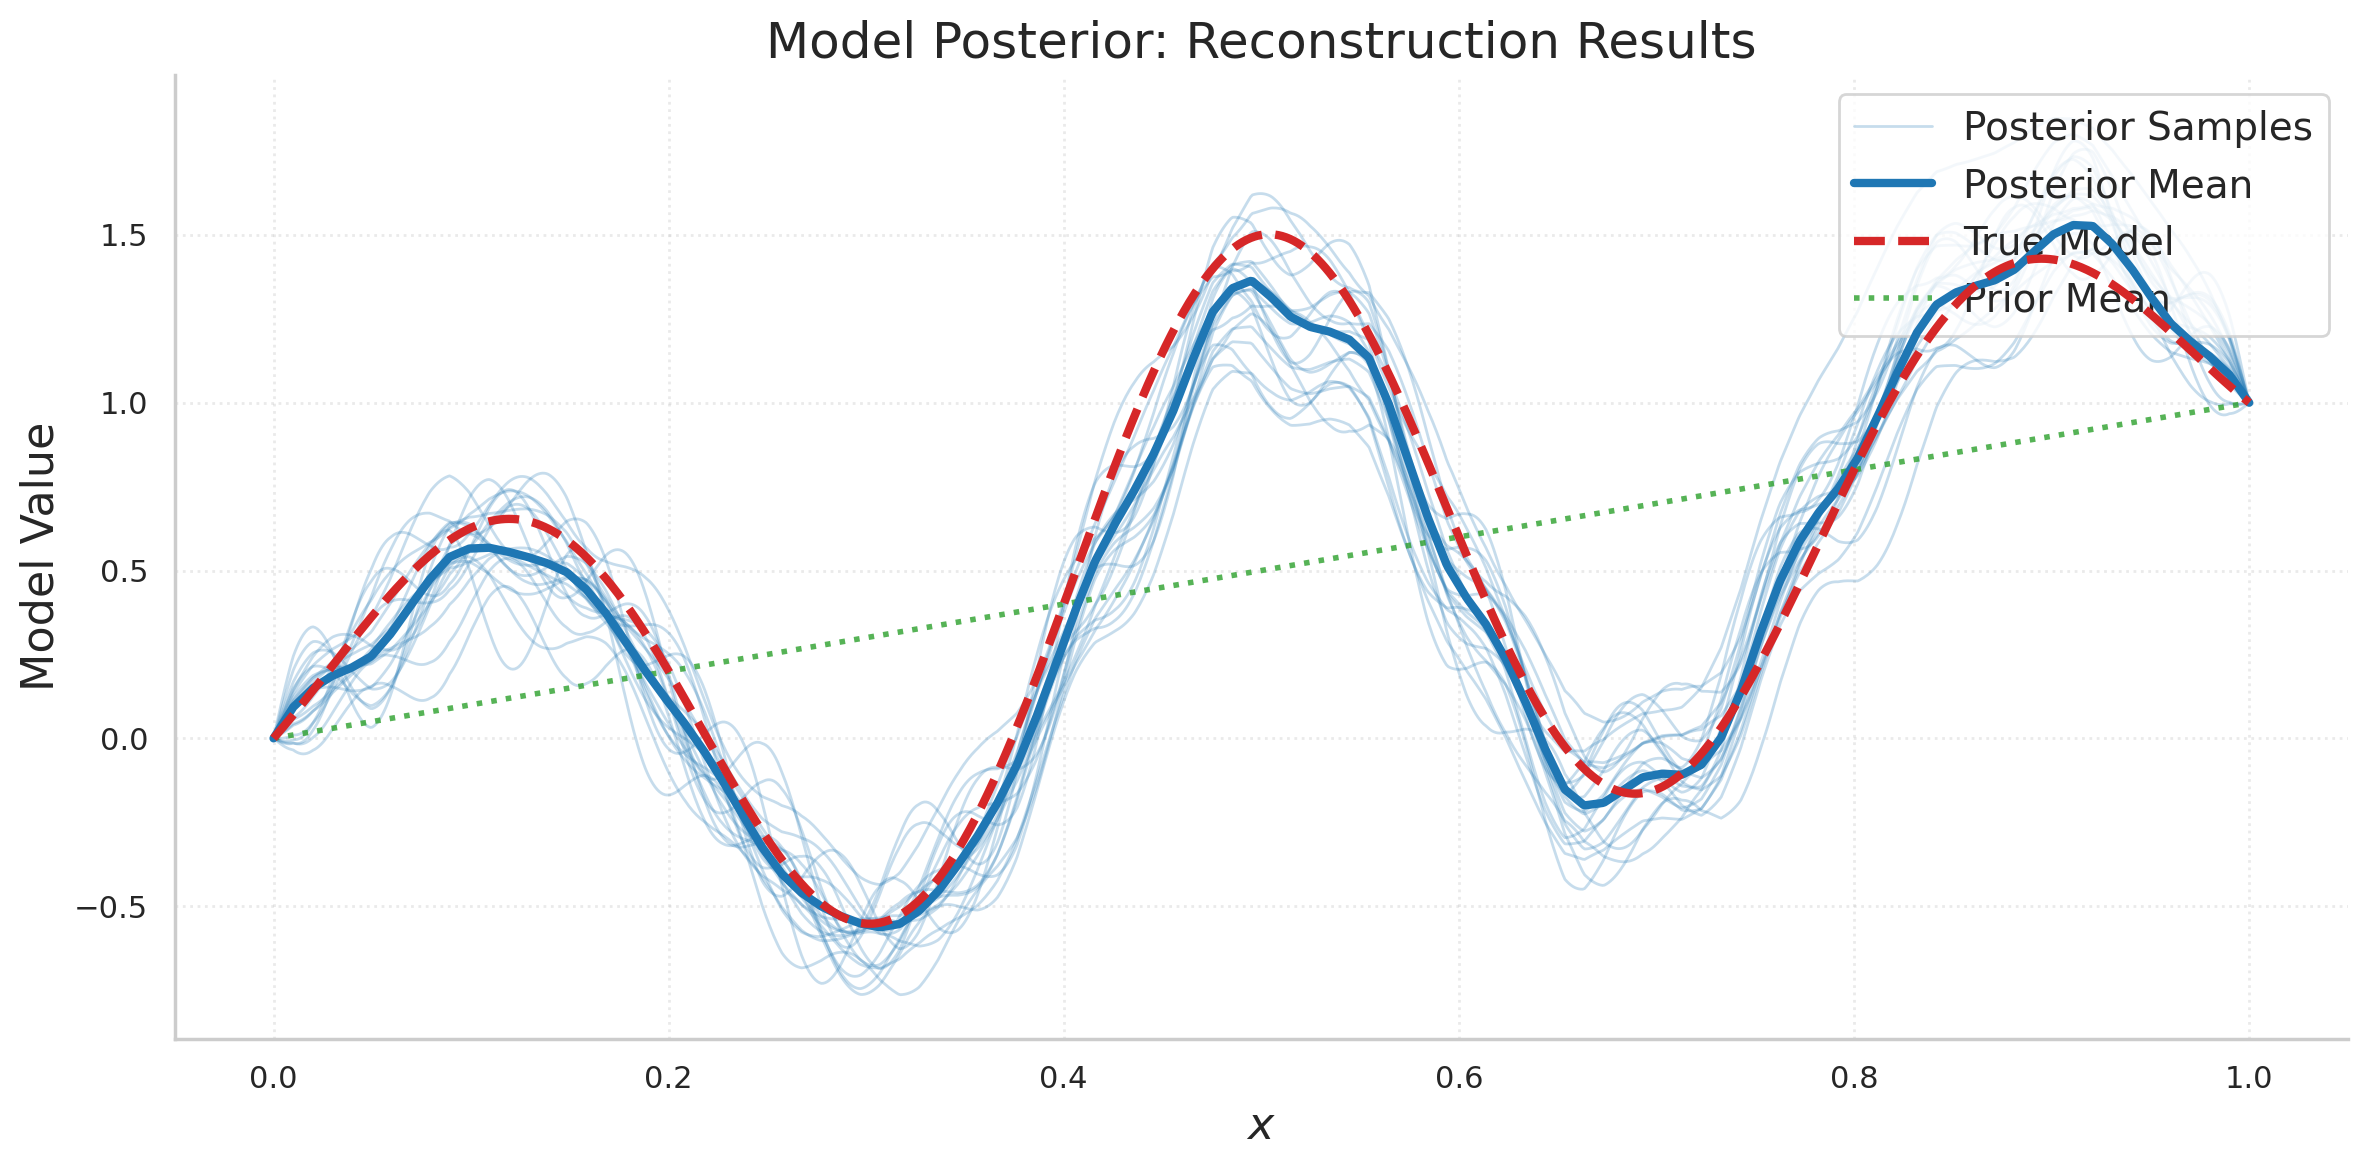

RMS reconstruction error: 0.0995
Relative error: 16.1%


In [95]:
# Visualize posterior measure on model space
fig_title = "Model Posterior Distribution"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 6), dpi=200)

# Plot posterior samples
num_samples = 20
sample_color = 'tab:blue'
print("Sampling from posterior...")
for i in range(num_samples):
    sample = mu_M.sample()
    plt.plot(x, sample.evaluate(x), color=sample_color, alpha=0.25, linewidth=1,
            label='Posterior Samples' if i == 0 else "")

# Plot key comparisons
plt.plot(x, mu_M.expectation.evaluate(x), color='tab:blue', linewidth=3,
        label='Posterior Mean', zorder=10)
plt.plot(x, m_bar.evaluate(x), color='tab:red', linestyle='--', linewidth=3,
        label='True Model', zorder=10)
plt.plot(x, M.gaussian_measure.expectation.evaluate(x), color='tab:green',
        linestyle=':', linewidth=2, alpha=0.8, label='Prior Mean', zorder=5)

plt.title("Model Posterior: Reconstruction Results", fontsize=18)
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel("Model Value", fontsize=16)
plt.legend(fontsize=14, loc='upper right')
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Compute reconstruction error
reconstruction_error = np.sqrt(np.mean((mu_M.expectation.evaluate(x) - m_bar.evaluate(x))**2))
print(f"RMS reconstruction error: {reconstruction_error:.4f}")
print(f"Relative error: {100 * reconstruction_error / np.std(m_bar.evaluate(x)):.1f}%")

### Property Posterior 

We can directly compute the property posterior without explicitly constructing the full model posterior:
$$\mu_{\mathcal{P}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\mathbf{\tilde{p}}, \mathbf{C}_{\mathcal{P}})$$

where:
- **Property mean**: $\mathbf{\tilde{p}} = \mathcal{T}(\tilde{m})$ 
- **Property covariance**: $\mathbf{C}_{\mathcal{P}} = \mathcal{T} C_{\mathcal{M}} \mathcal{T}^*$

This represents our final inferences about the local properties of interest.

In [96]:
# Compute property posterior using built-in methods
print("Computing property posterior...")

# Use the LinearBayesianInference class to compute property posterior directly
solver = CholeskySolver()
property_posterior = bayesian_inference.property_posterior_measure(d_tilde, solver)

# Extract property mean and covariance
p_tilde = property_posterior.expectation
cov_P_matrix = property_posterior.covariance.matrix(dense=True)

print(f"Property posterior mean computed for {len(p_tilde)} locations")
print(f"Property covariance matrix size: {cov_P_matrix.shape}")

Computing property posterior...
Property posterior mean computed for 10 locations
Property covariance matrix size: (10, 10)


In [97]:
from scipy.linalg import eigh
print(eigh(C_M_matrix)[0])  # Eigenvalues of the model posterior covariance
print(eigh(cov_P_matrix)[0])

[5.16063246e-06 8.29377193e-06 1.19140520e-05 1.24180918e-05
 1.39597223e-05 1.48776104e-05 1.95699458e-05 2.24813472e-05
 2.29306392e-05 2.47496470e-05 3.04019976e-05 3.59815231e-05
 4.44047083e-05 5.58668139e-05 8.05612648e-05 9.92766899e-05
 1.55530912e-04 2.21146144e-04 2.42213054e-04 2.91596165e-04
 3.51039718e-04 4.89823520e-04 6.78462970e-04 7.53760840e-04
 9.15639976e-04 9.75566834e-04 1.02192514e-03 2.39004441e-03
 3.10661923e-03 5.86557164e-03]
[0.00075868 0.00115384 0.00133881 0.00226024 0.00256563 0.00403376
 0.00744862 0.02134101 0.02920679 0.05836084]


In [98]:
# The property posterior measure is already created by LinearBayesianInference
# We can use it directly or create a new one with sampling capability
gaussian_P = GaussianMeasure.from_covariance_matrix(P, cov_P_matrix, expectation=p_tilde)
print("Property posterior Gaussian measure created successfully")

Property posterior Gaussian measure created successfully


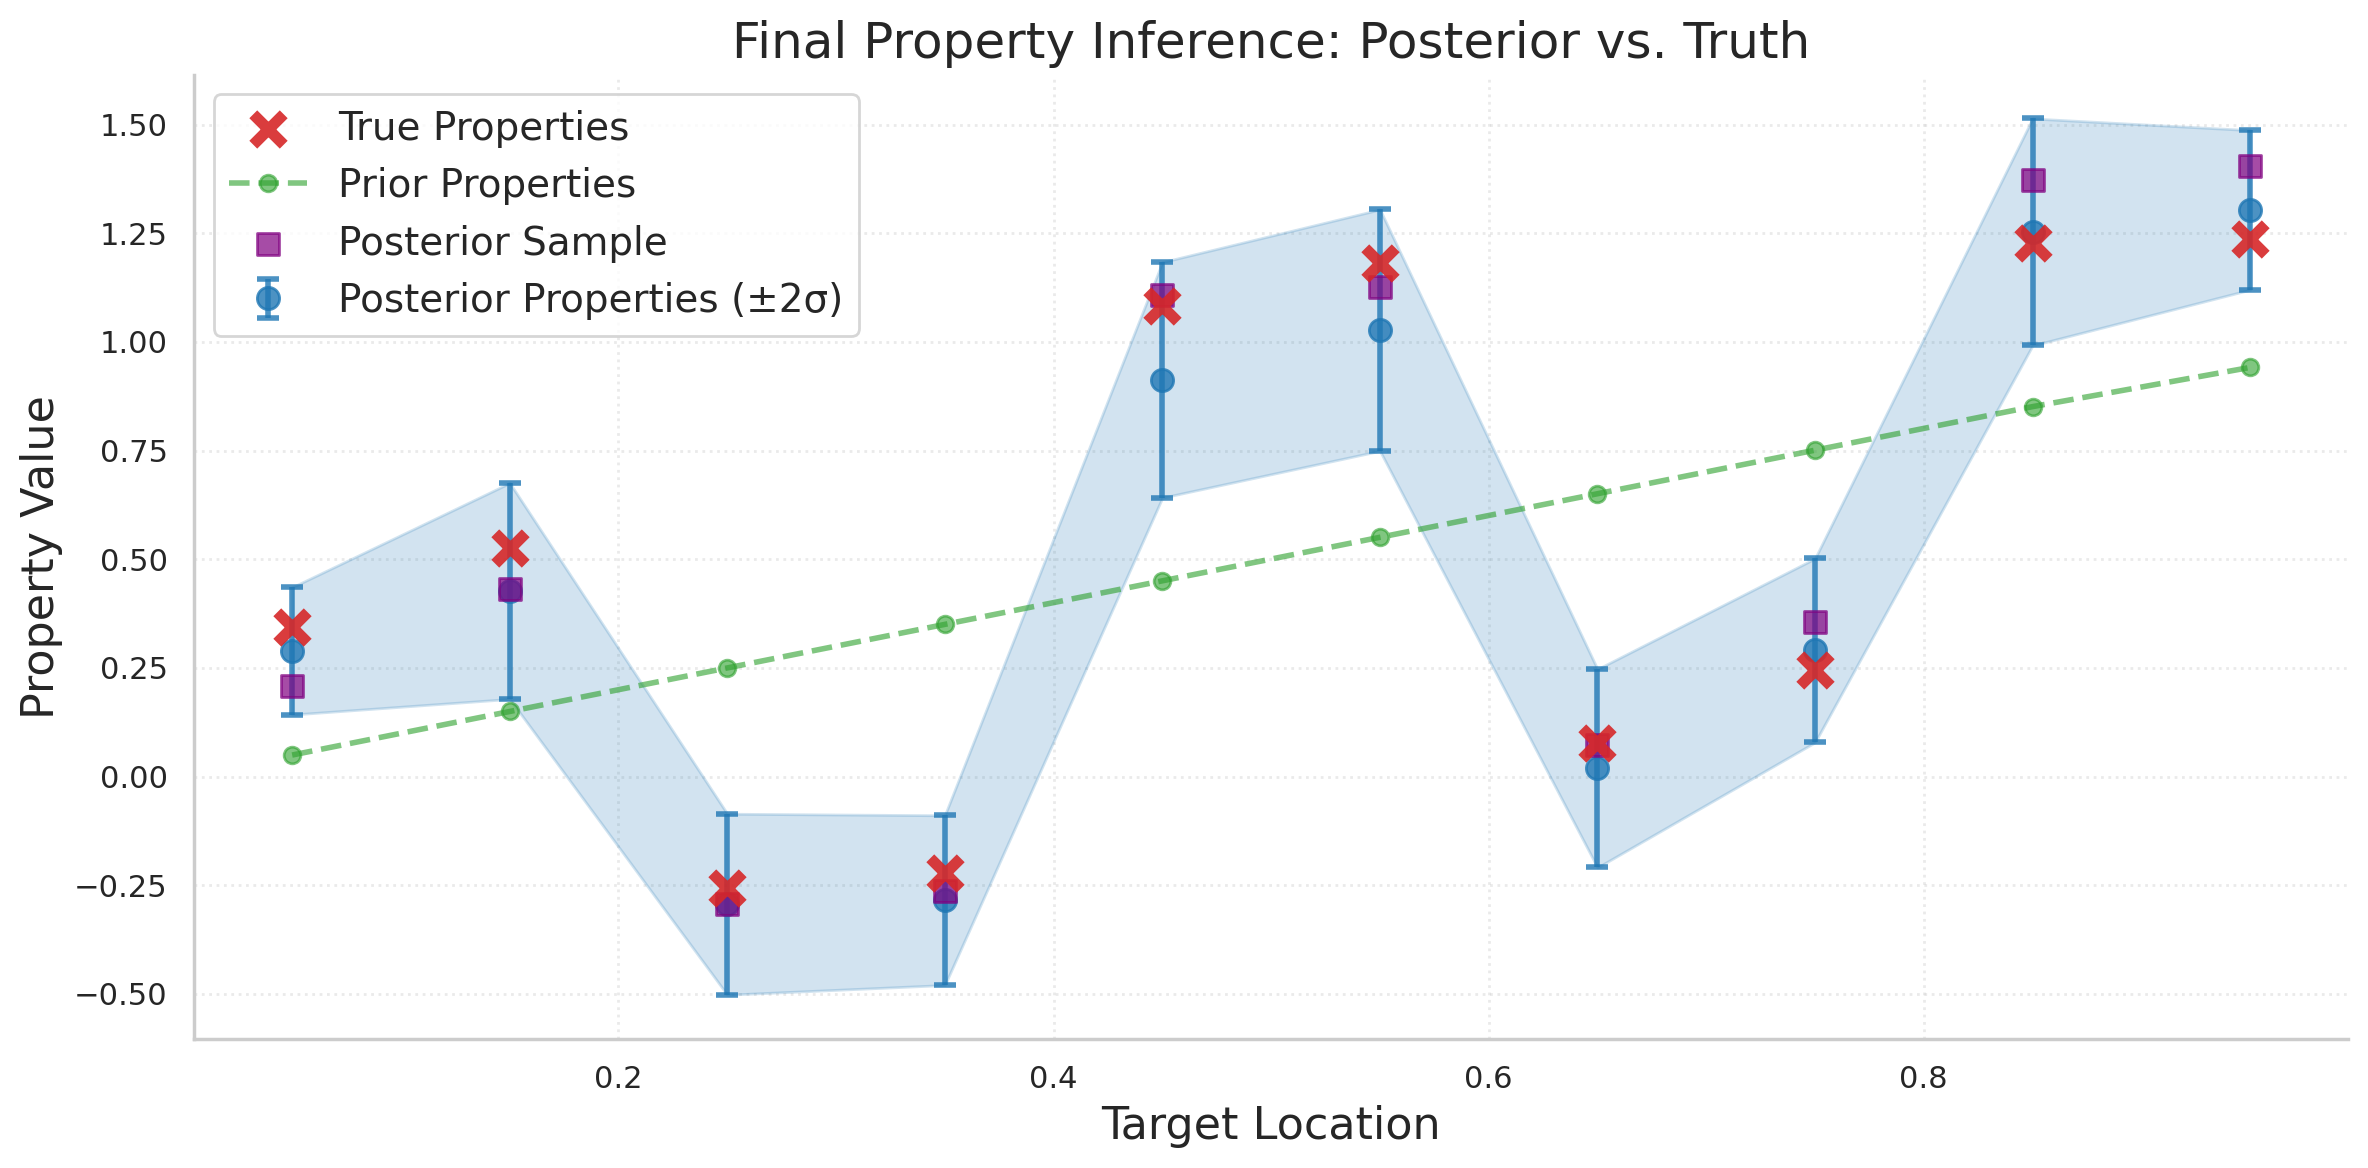


FINAL RESULTS SUMMARY
Properties successfully inferred: 10/10 (100.0%)
Mean absolute error: 0.0776
RMS error: 0.0904
Max error: 0.1694
Average uncertainty reduction: 90.5%


In [99]:
# Final property inference results
std_P_post = np.sqrt(np.diag(gaussian_P.covariance.matrix(dense=True)))

fig_title = "Property Inference Results"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 6), dpi=200)

# Property posterior with uncertainty
plt.errorbar(centers, p_tilde, yerr=2*std_P_post, fmt='o', color='tab:blue',
            alpha=0.8, capsize=4, capthick=2, markersize=8, linewidth=2,
            label='Posterior Properties (±2σ)')
plt.fill_between(centers, p_tilde - 2*std_P_post, p_tilde + 2*std_P_post,
                color='tab:blue', alpha=0.2)

# True properties
true_props = T(m_bar)
plt.scatter(centers, true_props, label='True Properties',
           color='tab:red', marker='x', s=120, alpha=0.9, linewidths=4, zorder=10)

# Prior for comparison
mean_prop_prior = T(M.gaussian_measure.expectation)
plt.plot(centers, mean_prop_prior, 'o--', color='tab:green', alpha=0.6,
        markersize=6, linewidth=2, label='Prior Properties')

# Sample from posterior
sampled_props_post = gaussian_P.sample()
plt.scatter(centers, sampled_props_post, label='Posterior Sample',
           color='purple', marker='s', s=60, alpha=0.7, zorder=5)

plt.xlabel('Target Location', fontsize=16)
plt.ylabel('Property Value', fontsize=16)
plt.title('Final Property Inference: Posterior vs. Truth', fontsize=18)
plt.legend(fontsize=14, loc='best')
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Quantitative assessment
property_errors = np.abs(p_tilde - true_props)
within_2sigma = np.sum(property_errors <= 2*std_P_post)

print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
print(f"Properties successfully inferred: {within_2sigma}/{len(true_props)} ({100*within_2sigma/len(true_props):.1f}%)")
print(f"Mean absolute error: {np.mean(property_errors):.4f}")
print(f"RMS error: {np.sqrt(np.mean(property_errors**2)):.4f}")
print(f"Max error: {np.max(property_errors):.4f}")
print(f"Average uncertainty reduction: {100*(1 - np.mean(std_P_post)/np.mean(std_P)):.1f}%")
print("="*50)